# COVID Cases to Predict Dow Jones Index

### Introduction

__With COVID-19 griping everyone's lives and finances we have all noticed the financial market dive and unemployment sky rocket. The question that everyone has is when will we bounce back and are we on that track yet?__

__More questions come from the volitiliy of the market, and the question on everyone's question in the financial world is, have we hit rock bottom?__

__I investigate Coronavirus (COVID-19), a respiratory disease caused by SARS-CoV-2, putting older adults and people with sever underlying meeidical condistion like heart or lung disease or diabetes at a greater risk for developing serious complications from COVID-19 illness. It is thought to spread mainly from person to person, mainly through respiratory droplets produced from coughin or sneezing of an infected person. Another way of transmission is through direct contact of an infected surface or person and then touching your face. As the world has not seen such an aggressive and deadly virus, there is still much that we are learning on the devastation it is having on people's lives and global economies. The United States of America along with the world faced the virus since 2019.__

In this analysis I have used __XGBoost__ as my machine learning model, and measured my accuracy with mean squared error and mean absolute error. __XGBoost__ is an optimized distributed gradient boosting library to be highly efficient, flexible, and portable. It implements machine learning under the __Gradient Boosting__ framework, as it provides a parallel tree boosting to solve data science problems in a fast and accurate way.

__Gradient boosting__ is a method that goes through cycles to iteratively add models into an ensemble. It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. However, subsequent additions to the ensemble will address those errors.

__Steps of Gradient Boosting:__
    - First use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble
    - The predictions are then used to calculate a loss function, which are my error values
    - Next we use the loss function to fit a new model that will be added to the ensemble. Specifically, I determined model parameters so that adding this new model to the ensemble will reduce the loss
    - Finally, we add the new model to ensemble and repeat until we have an accurate model.
    
__XGBoost Parameters:__
    - n_estimators -> Specifies how many times to go through the modeling cycle
    - max_depth -> Maximum depth of a tree, large value can cause overfitting
    - learning_rate -> Shrinkage factor that avoids overfitting of the model
    - subsample -> Subsample ratio of the training instances, it will occur once in every boosting iteration
    - colsample_bytree -> Subsample ratio of columns when constructing each tree
    - colsample_bylevel -> Subsample ratio of columns for each level
    - gamma -> Minimum loss reduction required to make a futher partition of a leaf node of the tree

#### Import Necessary Libraries

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

%matplotlib notebook
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import Common_Functions as cf
import time
import mplcursors

from matplotlib.backends.backend_agg import FigureCanvasAgg 
plt.get_backend()


test_size = 0.2
valid_size = 0.2
N = 21


n_estimators = 100
max_depth = 3
learning_rate = 0.1
min_child_weight = 1
subsample = 1
colsample_bytree = 1
colsample_bylevel = 1
gamma = 0
model_seed = 100


style.use('seaborn-darkgrid')

### Load and Format Dataset

The dataset has already been merged on the dates of COVID cases dates, with the cases summed up per date, and the OHLC data along with cases. I have taken the dataset and formatted it for greater readability and analysis. The dates column is changed into datetime data type.

In [3]:
COVID_DJI = pd.read_csv('COVID_DJI.csv', parse_dates = True, index_col = 0)
COVID_DJI.head()

,Date,fips,cases,deaths,High,Low,Open,Close,Volume,Adj Close
0,2020-01-21,53,1,0,29341.210938,29146.470703,29269.050781,29196.039062,320640000,29196.039062
1,2020-01-22,53,1,0,29320.199219,29172.259766,29263.630859,29186.269531,283440000,29186.269531
2,2020-01-23,53,1,0,29190.470703,28966.980469,29111.019531,29160.089844,307060000,29160.089844
3,2020-01-24,70,2,0,29288.789062,28843.310547,29230.390625,28989.730469,380010000,28989.730469
4,2020-01-27,80,5,0,28671.789062,28440.470703,28542.490234,28535.800781,337270000,28535.800781


In [4]:
COVID_DJI.columns = [str(col).upper().replace(' ', '_') for col in COVID_DJI.columns]
COVID_DJI.head()

,DATE,FIPS,CASES,DEATHS,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE
0,2020-01-21,53,1,0,29341.210938,29146.470703,29269.050781,29196.039062,320640000,29196.039062
1,2020-01-22,53,1,0,29320.199219,29172.259766,29263.630859,29186.269531,283440000,29186.269531
2,2020-01-23,53,1,0,29190.470703,28966.980469,29111.019531,29160.089844,307060000,29160.089844
3,2020-01-24,70,2,0,29288.789062,28843.310547,29230.390625,28989.730469,380010000,28989.730469
4,2020-01-27,80,5,0,28671.789062,28440.470703,28542.490234,28535.800781,337270000,28535.800781


In [5]:
COVID_DJI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 66
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       67 non-null     object 
 1   FIPS       67 non-null     int64  
 2   CASES      67 non-null     int64  
 3   DEATHS     67 non-null     int64  
 4   HIGH       67 non-null     float64
 5   LOW        67 non-null     float64
 6   OPEN       67 non-null     float64
 7   CLOSE      67 non-null     float64
 8   VOLUME     67 non-null     int64  
 9   ADJ_CLOSE  67 non-null     float64
dtypes: float64(5), int64(4), object(1)
memory usage: 5.8+ KB


In [6]:
COVID_DJI.loc[:, 'DATE'] = pd.to_datetime(COVID_DJI['DATE'], format = '%Y-%m-%d')

In [7]:
COVID_DJI.dtypes

DATE         datetime64[ns]
FIPS                  int64
CASES                 int64
DEATHS                int64
HIGH                float64
LOW                 float64
OPEN                float64
CLOSE               float64
VOLUME                int64
ADJ_CLOSE           float64
dtype: object

### Graphing Adjusted Close and Volume of DJI

I have graphed the adjusted close and volume of DJI over time and we can see a significant drop in the price a little after 02/15/2020 with an increase of volume of shares during the same period as more people went short on their stocks of companies in the Dow Jones Index.

<IPython.core.display.Javascript object>


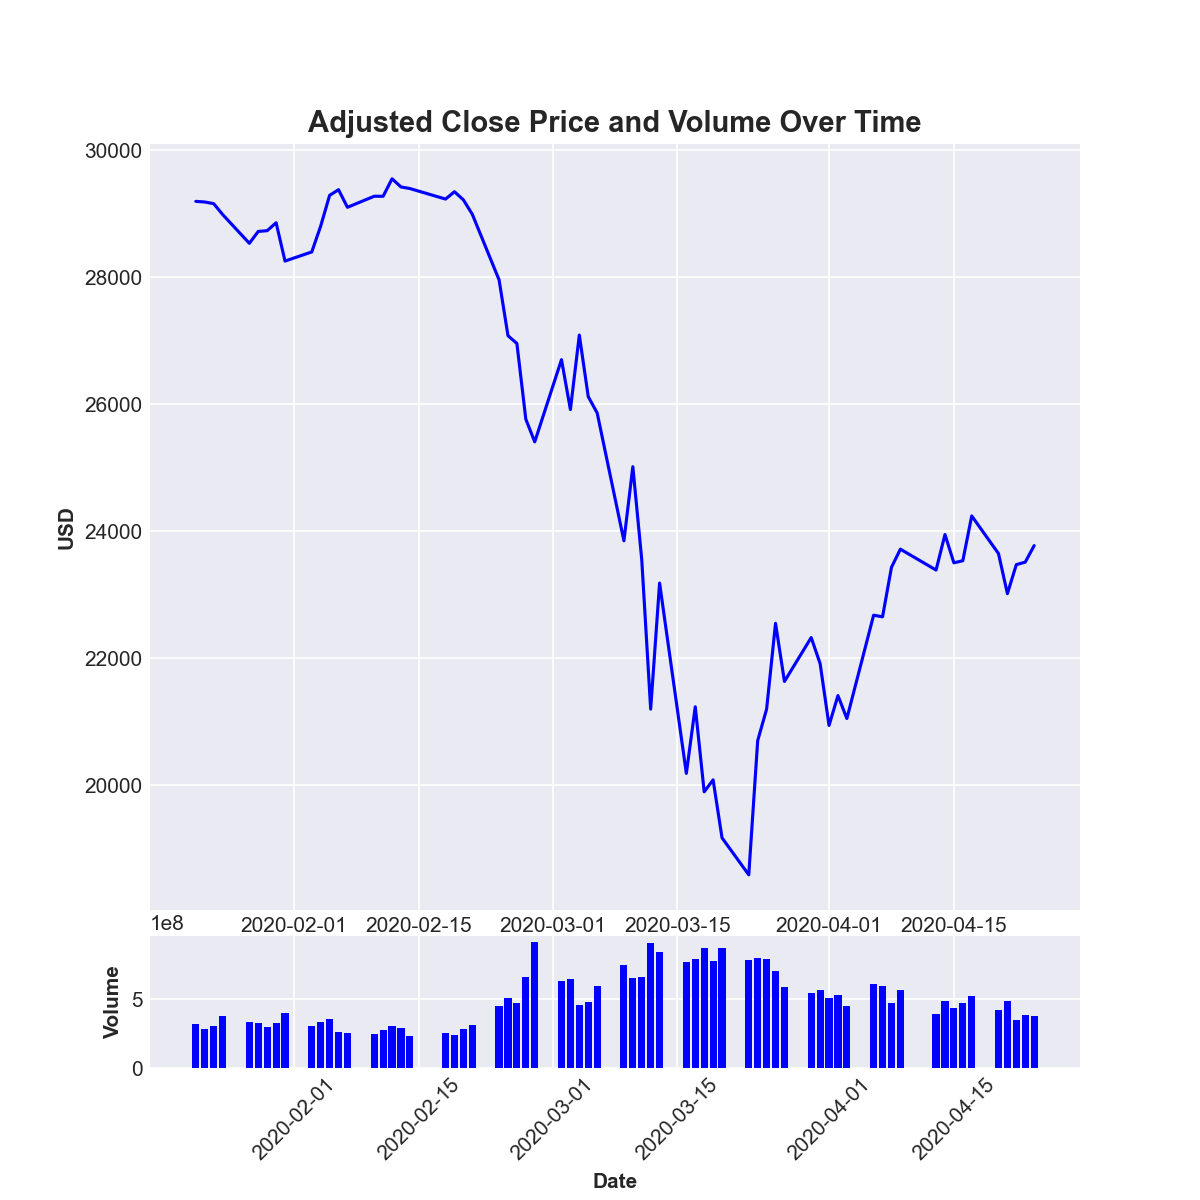

In [8]:
rcParams['figure.figsize'] = 8, 8

plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 1, colspan = 1, sharex = ax1)

ax1.plot(COVID_DJI['DATE'], COVID_DJI['ADJ_CLOSE'], 'b-')
ax1.set_ylabel('USD', fontweight = 'bold')
ax1.set_title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
ax1.grid(True)

ax2.bar(COVID_DJI['DATE'], COVID_DJI['VOLUME'], color = 'blue')
ax2.grid(True)
ax2.set_ylabel('Volume', fontweight = 'bold')

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

### Feature Engineering

For better analysis I have added the range of high and low as well as range of open and close of the prices each day. Lag columns are created for the past 21 days allowing constant feed of data into the XGBoost model for better predictions. The mean and standard deviation of columns is also calculated to help with scaling in the next steps.

In [9]:
COVID_DJI['RANGE_HL'] = COVID_DJI['HIGH'] - COVID_DJI['LOW']
COVID_DJI['RANGE_OC'] = COVID_DJI['OPEN'] - COVID_DJI['CLOSE']
COVID_DJI.head()

,DATE,FIPS,CASES,DEATHS,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,RANGE_HL,RANGE_OC
0,2020-01-21,53,1,0,29341.210938,29146.470703,29269.050781,29196.039062,320640000,29196.039062,194.740234,73.011719
1,2020-01-22,53,1,0,29320.199219,29172.259766,29263.630859,29186.269531,283440000,29186.269531,147.939453,77.361328
2,2020-01-23,53,1,0,29190.470703,28966.980469,29111.019531,29160.089844,307060000,29160.089844,223.490234,-49.070312
3,2020-01-24,70,2,0,29288.789062,28843.310547,29230.390625,28989.730469,380010000,28989.730469,445.478516,240.660156
4,2020-01-27,80,5,0,28671.789062,28440.470703,28542.490234,28535.800781,337270000,28535.800781,231.318359,6.689453


In [10]:
COVID_DJI['ORDER'] = [idx for idx in list(range(len(COVID_DJI)))]

merging_keys = ['ORDER']

lag_cols = ['CASES', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']
lag_cols

['CASES',
 'OPEN',
 'HIGH',
 'LOW',
 'CLOSE',
 'ADJ_CLOSE',
 'VOLUME',
 'RANGE_HL',
 'RANGE_OC']

In [11]:
days_lagging = [day+1 for day in range(N)]

for lag in tqdm_notebook(days_lagging):
    train_lag = COVID_DJI[merging_keys + lag_cols].copy()
    
    train_lag['ORDER'] = train_lag['ORDER'] + lag
    
    foo = lambda num: '{}_LAG_{}'.format(num, lag) if num in lag_cols else num
    train_lag = train_lag.rename(columns = foo)
    
    COVID_DJI = pd.merge(COVID_DJI, train_lag, on = merging_keys, how = 'left')
    
del train_lag

COVID_DJI = COVID_DJI[N:]

COVID_DJI.head()

<ipython-input-11-53d7c9a012c6>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lag in tqdm_notebook(days_lagging):


,DATE,FIPS,CASES,DEATHS,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,...,RANGE_OC_LAG_20,CASES_LAG_21,OPEN_LAG_21,HIGH_LAG_21,LOW_LAG_21,CLOSE_LAG_21,ADJ_CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21
21,2020-02-20,239,27,0,29368.449219,28959.650391,29296.250000,29219.980469,287780000,29219.980469,...,77.361328,1.0,29269.050781,29341.210938,29146.470703,29196.039062,29196.039062,320640000.0,194.740234,73.011719
22,2020-02-21,239,30,0,29146.529297,28892.699219,29146.529297,28992.410156,311210000,28992.410156,...,-49.070312,1.0,29263.630859,29320.199219,29172.259766,29186.269531,29186.269531,283440000.0,147.939453,77.361328
23,2020-02-24,239,43,0,28402.929688,27912.439453,28402.929688,27960.800781,452580000,27960.800781,...,240.660156,1.0,29111.019531,29190.470703,28966.980469,29160.089844,29160.089844,307060000.0,223.490234,-49.070312
24,2020-02-25,288,45,0,28149.199219,26997.619141,28037.650391,27081.359375,513270000,27081.359375,...,6.689453,2.0,29230.390625,29288.789062,28843.310547,28989.730469,28989.730469,380010000.0,445.478516,240.660156
25,2020-02-26,288,60,0,27542.779297,26890.970703,27159.460938,26957.589844,472450000,26957.589844,...,-128.570312,5.0,28542.490234,28671.789062,28440.470703,28535.800781,28535.800781,337270000.0,231.318359,6.689453


In [12]:
COVID_DJI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 21 to 66
Columns: 202 entries, DATE to RANGE_OC_LAG_21
dtypes: datetime64[ns](1), float64(196), int64(5)
memory usage: 73.0 KB


In [13]:
for col in lag_cols:
    COVID_DJI = cf.get_mov_avg_std(COVID_DJI, col)
    
COVID_DJI.head()

,DATE,FIPS,CASES,DEATHS,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,...,CLOSE_MEAN,CLOSE_STD,ADJ_CLOSE_MEAN,ADJ_CLOSE_STD,VOLUME_MEAN,VOLUME_STD,RANGE_HL_MEAN,RANGE_HL_STD,RANGE_OC_MEAN,RANGE_OC_STD
21,2020-02-20,239,27,0,29368.449219,28959.650391,29296.250000,29219.980469,287780000,29219.980469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2020-02-21,239,30,0,29146.529297,28892.699219,29146.529297,28992.410156,311210000,28992.410156,...,29219.980469,NaN,29219.980469,NaN,2.877800e+08,NaN,408.798828,NaN,76.269531,NaN
23,2020-02-24,239,43,0,28402.929688,27912.439453,28402.929688,27960.800781,452580000,27960.800781,...,29106.195312,160.916511,29106.195312,160.916511,2.994950e+08,1.656751e+07,331.314453,109.579454,115.194336,55.047987
24,2020-02-25,288,45,0,28149.199219,26997.619141,28037.650391,27081.359375,513270000,27081.359375,...,28724.397135,671.011629,28724.397135,671.011629,3.505233e+08,8.915668e+07,384.373047,120.205954,224.172526,192.727471
25,2020-02-26,288,60,0,27542.779297,26890.970703,27159.460938,26957.589844,472450000,26957.589844,...,28313.637695,987.453463,28313.637695,987.453463,3.912100e+08,1.091829e+08,576.174805,395.960400,407.202148,398.449440


### Splitting Train, Validation, and Test Dataset

I have used 60% of the data for training on, then 20% to validate and tune, finally the last 20% for testing the optimized XGBoost model

In [14]:
valid_len = int(valid_size * len(COVID_DJI))
test_len = int(test_size * len(COVID_DJI))
train_len = len(COVID_DJI) - (valid_len + test_len)
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))
print('Valid Set Len: ' + str(valid_len))

train = COVID_DJI[:train_len]
valid = COVID_DJI[train_len:(train_len + valid_len)]
test = COVID_DJI[(train_len + valid_len):]
print('Train Set Shape: ' + str(train.shape))
print('Valid Set Shape: ' + str(valid.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 28
Test Set Len: 9
Valid Set Len: 9
Train Set Shape: (28, 220)
Valid Set Shape: (9, 220)
Test Set Shape: (9, 220)


### Scaling Data

When looking at time-series stock data, the prices of stocks overall goes up, therefore the later dates will have a higher stock price compared to the earlier stock prices. In order to have a levled analysis I have scaled all of the data across the entire dataframe, this evens out the playing field for analysis. Also the unnecessary data columns were removed allowing for better readability while implementing XGBoost.

In [15]:
scaling_cols = ['ADJ_CLOSE']

for num in range(1, N+1):
    scaling_cols.append('CASES_LAG_'+str(num))
    scaling_cols.append('OPEN_LAG_'+str(num))
    scaling_cols.append('HIGH_LAG_'+str(num))
    scaling_cols.append('LOW_LAG_'+str(num))
    scaling_cols.append('ADJ_CLOSE_LAG_'+str(num))
    scaling_cols.append('VOLUME_LAG_'+str(num))
    scaling_cols.append('RANGE_HL_LAG_'+str(num))
    scaling_cols.append('RANGE_OC_LAG_'+str(num))
    
scaler = StandardScaler()
train_scale = scaler.fit_transform(train[scaling_cols])
train_df_scaled = pd.DataFrame(train_scale, columns = scaling_cols)
train_df_scaled[['DATE']] = train.reset_index()[['DATE']]
train_df_scaled

,ADJ_CLOSE,CASES_LAG_1,OPEN_LAG_1,HIGH_LAG_1,LOW_LAG_1,ADJ_CLOSE_LAG_1,VOLUME_LAG_1,RANGE_HL_LAG_1,RANGE_OC_LAG_1,CASES_LAG_2,...,RANGE_OC_LAG_20,CASES_LAG_21,OPEN_LAG_21,HIGH_LAG_21,LOW_LAG_21,ADJ_CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21,DATE
0,1.749888,-0.524307,1.567963,1.546937,1.688663,1.630895,-2.203346,-2.158297,-0.176185,-0.491885,...,0.073256,-0.992052,0.581694,0.554683,0.599312,0.541794,-0.253058,-0.638782,-0.072363,2020-02-20
1,1.675882,-0.524235,1.562937,1.533756,1.595723,1.591179,-1.951012,-1.534846,-0.020897,-0.491885,...,-0.278347,-0.992052,0.575963,0.531143,0.622671,0.532515,-0.515161,-0.818258,-0.056902,2020-02-21
2,1.340399,-0.524128,1.517189,1.461780,1.575952,1.520596,-1.825595,-1.887341,0.087429,-0.491796,...,0.527386,-0.992052,0.414594,0.385803,0.436739,0.507652,-0.348740,-0.528529,-0.506296,2020-02-24
3,1.054401,-0.523664,1.289982,1.220607,1.286481,1.200630,-1.068861,-1.349028,0.488186,-0.491662,...,-0.123280,-0.937904,0.540815,0.495953,0.324725,0.345860,0.165248,0.322774,0.523534,2020-02-25
4,1.014151,-0.523592,1.178371,1.138314,1.016334,0.927862,-0.743996,0.154703,1.203628,-0.491081,...,-0.499434,-0.775463,-0.186562,-0.195293,-0.040147,-0.085243,-0.135887,-0.498509,-0.308101,2020-02-26
5,0.626850,-0.523056,0.910040,0.941632,0.984841,0.889473,-0.962500,-0.982090,0.153874,-0.490991,...,0.097503,-0.775463,-0.131801,-0.025628,0.082382,0.092400,-0.186124,-0.436529,-0.788875,2020-02-27
6,0.510661,-0.523056,0.716485,0.692716,0.648745,0.520087,0.068086,-0.138928,0.929604,-0.490320,...,-0.751693,-0.775463,0.107433,0.109943,0.220454,0.103416,-0.382348,-0.557058,-0.025912,2020-02-28
7,0.931461,-0.522877,0.332967,0.277223,0.332239,0.409272,1.411708,-0.614916,-0.319783,-0.490320,...,1.407145,-0.721316,-0.083287,0.037649,0.004497,0.222121,-0.209304,0.109832,-1.111294,2020-03-02
8,0.675881,-0.521483,0.430646,0.670292,0.542183,0.810609,-0.080616,0.524622,-1.675468,-0.490097,...,-0.364807,-0.667169,0.099513,-0.037046,-0.285552,-0.350945,0.333501,1.082203,1.647981,2020-03-03
9,1.057491,-0.520733,0.788739,0.793026,0.635001,0.566850,-0.027730,0.670429,1.048854,-0.488353,...,-0.450267,-0.450581,-0.422191,-0.241673,-0.149580,-0.214394,-0.342751,-0.193934,-0.616803,2020-03-04


In [16]:
valid_df_scaled = valid[['DATE']]
for col in tqdm_notebook(lag_cols):
    feat_list = [col + '_LAG_' + str(shift) for shift in range(1, N+1)]
    temp = valid.apply(lambda row: cf.scale_row(row[feat_list], row[col+'_MEAN'], row[col+'_STD']), axis = 1)
    valid_df_scaled = pd.concat([valid_df_scaled, temp], axis = 1)
        
    
valid_df_scaled.head()

<ipython-input-16-d95a67c972b6>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(lag_cols):


,DATE,CASES_LAG_1,CASES_LAG_2,CASES_LAG_3,CASES_LAG_4,CASES_LAG_5,CASES_LAG_6,CASES_LAG_7,CASES_LAG_8,CASES_LAG_9,...,RANGE_OC_LAG_12,RANGE_OC_LAG_13,RANGE_OC_LAG_14,RANGE_OC_LAG_15,RANGE_OC_LAG_16,RANGE_OC_LAG_17,RANGE_OC_LAG_18,RANGE_OC_LAG_19,RANGE_OC_LAG_20,RANGE_OC_LAG_21
49,2020-03-31,1.615178,0.185360,-0.219482,-0.619060,-0.961996,-1.206681,-1.805461,-1.937166,-2.032057,...,-1.213645,2.643460,2.761705,-0.077818,2.919667,0.198994,1.882098,-0.327276,2.399250,-1.039771
50,2020-04-01,1.285884,0.812044,-0.366937,-0.700756,-1.030235,-1.313009,-1.514768,-2.008503,-2.117103,...,1.671227,-1.588369,2.099638,2.212699,-0.502337,2.363737,-0.237661,1.371655,-0.740859,1.866134
51,2020-04-02,1.154648,0.672091,0.229388,-0.872122,-1.184005,-1.491834,-1.756026,-1.944527,-2.405818,...,-0.883999,1.405915,-1.598320,1.800763,1.904968,-0.597369,2.044172,-0.353428,1.129812,-0.817205
52,2020-04-03,1.141579,0.596495,0.100875,-0.353812,-1.485137,-1.805463,-2.121624,-2.392967,-2.586572,...,0.751478,-1.354993,1.641053,-2.289587,2.157661,2.293998,-0.979976,2.476129,-0.660812,1.279810
53,2020-04-06,1.324823,0.597320,-0.059734,-0.657162,-1.205248,-2.568966,-2.955091,-3.336198,-3.663279,...,-0.348143,0.770386,-1.356650,1.668645,-2.300368,2.190296,2.327964,-0.977972,2.511873,-0.655692


In [17]:
test_df_scaled = test[['DATE']]
for col in tqdm_notebook(lag_cols):
    feat_list = [col + '_LAG_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: cf.scale_row(row[feat_list], row[col+'_MEAN'], row[col+'_STD']), axis = 1)
    test_df_scaled = pd.concat([test_df_scaled, temp], axis = 1)
        
    
test_df_scaled.head()

<ipython-input-17-3ce69a9aa9d0>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(lag_cols):


,DATE,CASES_LAG_1,CASES_LAG_2,CASES_LAG_3,CASES_LAG_4,CASES_LAG_5,CASES_LAG_6,CASES_LAG_7,CASES_LAG_8,CASES_LAG_9,...,RANGE_OC_LAG_12,RANGE_OC_LAG_13,RANGE_OC_LAG_14,RANGE_OC_LAG_15,RANGE_OC_LAG_16,RANGE_OC_LAG_17,RANGE_OC_LAG_18,RANGE_OC_LAG_19,RANGE_OC_LAG_20,RANGE_OC_LAG_21
58,2020-04-14,1.608757,0.194576,-0.220231,-0.601244,-0.981858,-2.064644,-2.456507,-2.810424,-3.132223,...,-1.390598,-0.106623,-1.251596,0.700200,1.584178,-0.253740,0.498494,-0.931983,1.102593,-1.566653
59,2020-04-15,1.196716,0.913045,-0.344428,-0.713270,-1.052062,-1.390500,-2.353301,-2.701741,-3.016439,...,0.343685,-2.103730,-0.405561,-1.919887,0.661532,1.830670,-0.600136,0.394759,-1.497171,1.193732
60,2020-04-16,1.018887,0.694179,0.405889,-0.872054,-1.246901,-1.591208,-1.935155,-2.913629,-3.267742,...,-1.725736,1.058810,-3.053981,-0.200271,-2.745041,1.592941,3.557634,-0.527247,1.144638,-2.034682
61,2020-04-17,0.980349,0.579854,0.201065,-0.135240,-1.626029,-2.063307,-2.464959,-2.866192,-4.007634,...,1.296604,-3.275245,1.152873,-5.387484,-0.849377,-4.896193,2.002273,5.126622,-1.369350,1.289360
62,2020-04-20,1.291353,0.629803,-0.035063,-0.663895,-1.222199,-3.697076,-4.423006,-5.089795,-5.755886,...,1.166177,1.191619,-2.046925,1.089805,-3.543164,-0.328522,-3.195150,1.691491,3.904675,-0.696853


### Build XGBoost

I have made the features list of data that will be fed into the machine learning model. I also build the X and Y data for train, valid, and test datasets for the scled and unsclaed data. I then went ahead ran the model on the train and validation datasets.

In [18]:
features_list = []
for num in range(1, N+1):
    features_list.append('CASES_LAG_'+str(num))
    features_list.append('OPEN_LAG_'+str(num))
    features_list.append('HIGH_LAG_'+str(num))
    features_list.append('LOW_LAG_'+str(num))
    features_list.append('ADJ_CLOSE_LAG_'+str(num))
    features_list.append('VOLUME_LAG_'+str(num))
    features_list.append('RANGE_HL_LAG_'+str(num))
    features_list.append('RANGE_OC_LAG_'+str(num))
    
target = 'ADJ_CLOSE'

X_train = train[features_list]
y_train = train[target]
X_valid = valid[features_list]
y_valid = valid[target]
X_test = test[features_list]
y_test = test[target]

In [19]:
X_train_scaled = train_df_scaled[features_list]
y_train_scaled = train_df_scaled[target]
X_valid_scaled = valid_df_scaled[features_list]
X_test_scaled = test_df_scaled[features_list]

<IPython.core.display.Javascript object>


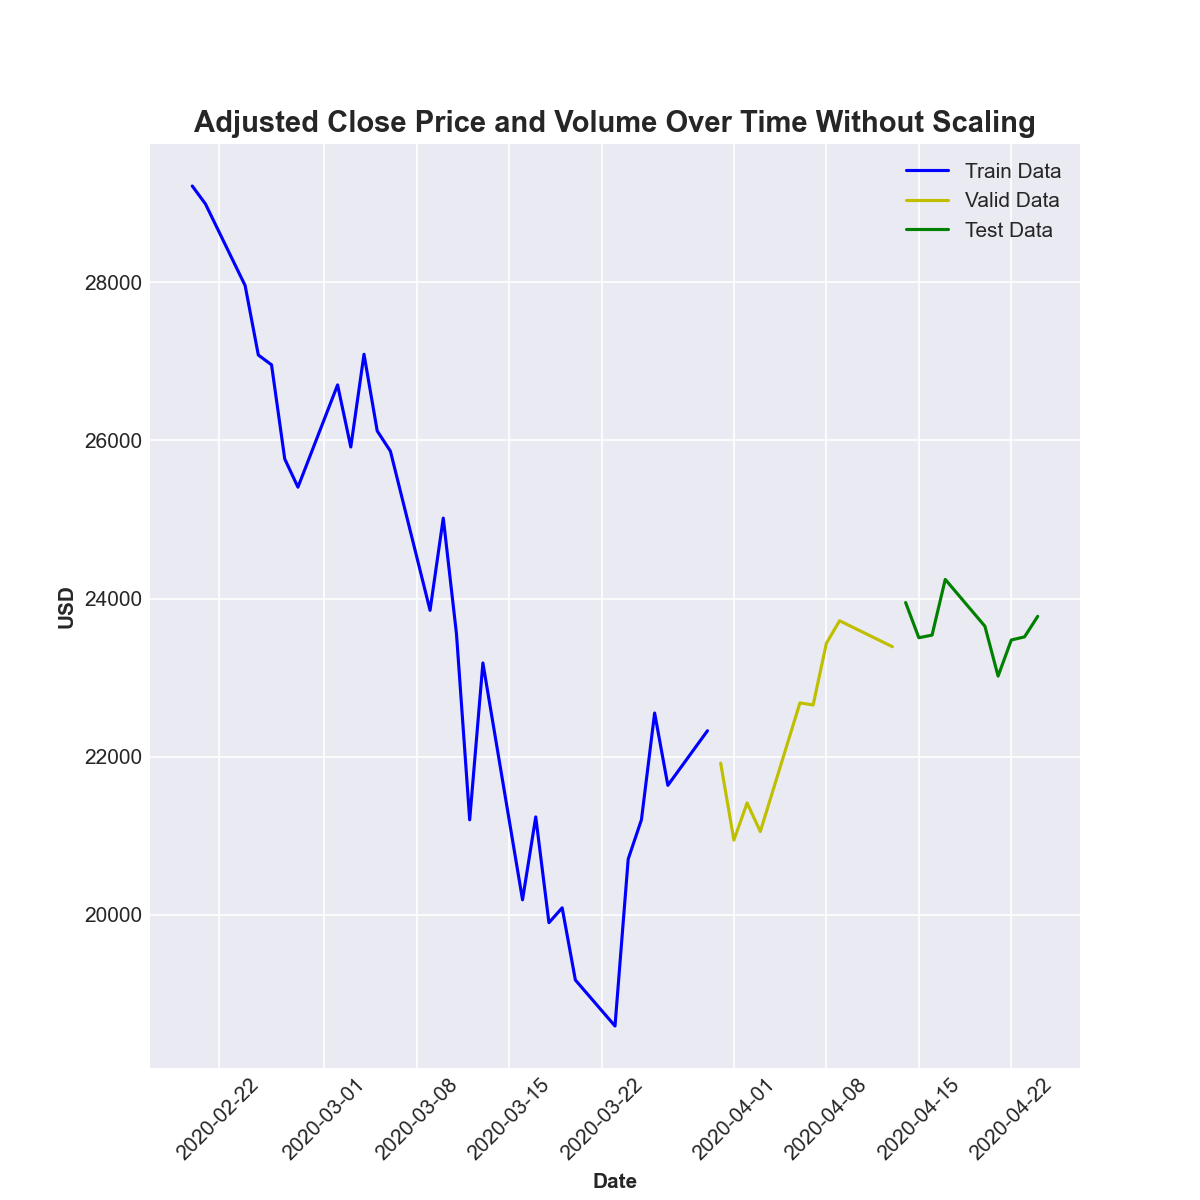

In [20]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.legend(['Train Data', 'Valid Data', 'Test Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xticks(rotation = 45)

plt.xlabel('Date', fontweight = 'bold')

mplcursors.cursor(hover = True)

plt.show()

<IPython.core.display.Javascript object>


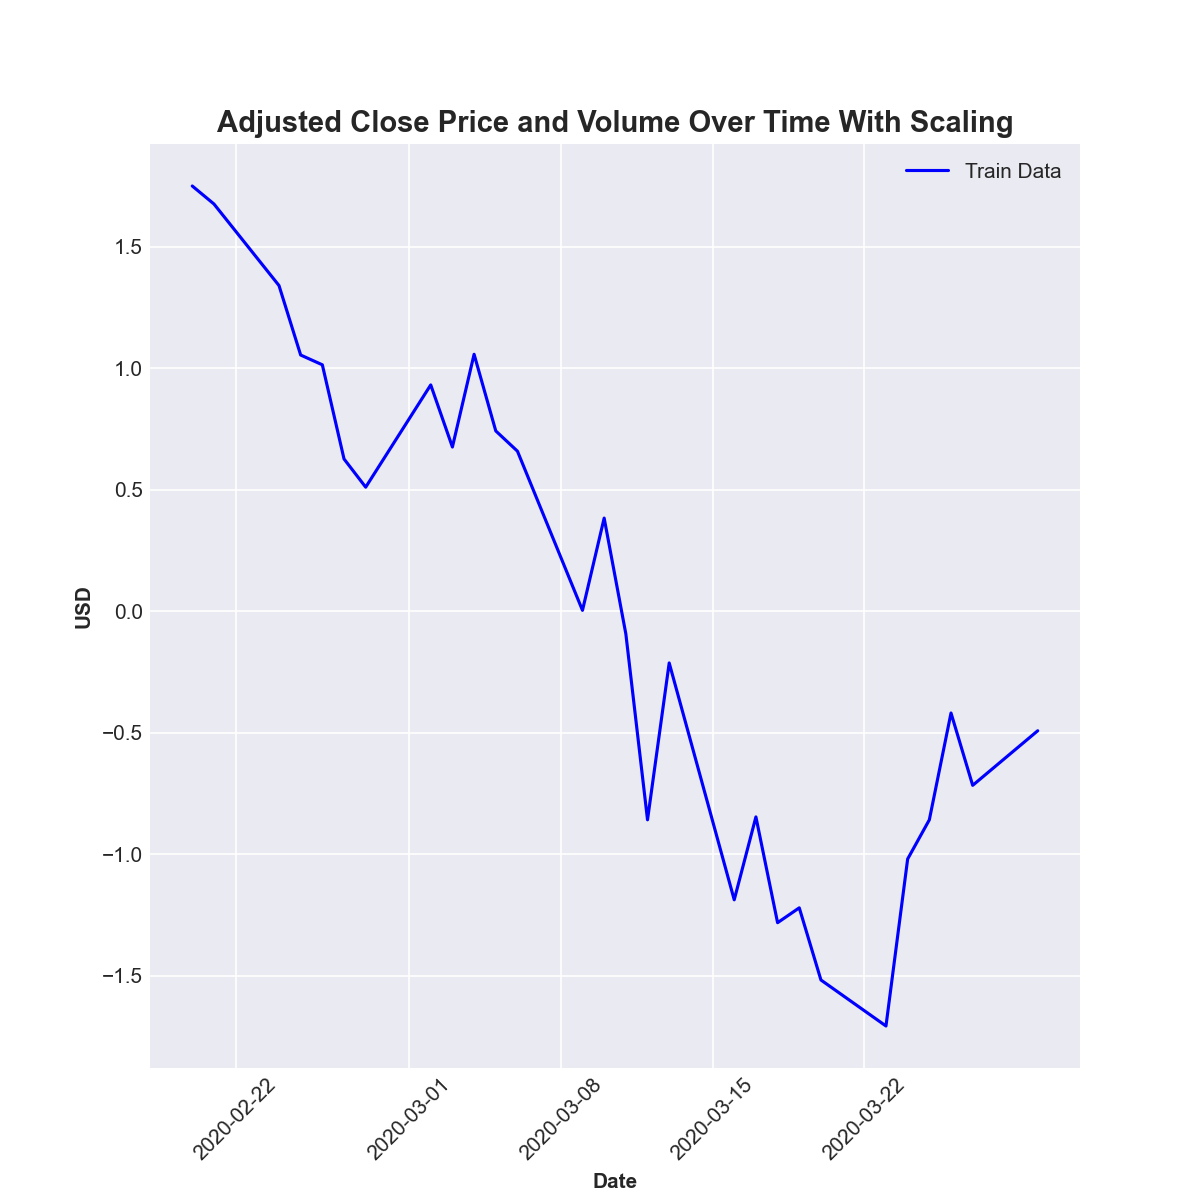

In [21]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train_df_scaled['DATE'], train_df_scaled['ADJ_CLOSE'], 'b-')
plt.legend(['Train Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time With Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [22]:
model = XGBRegressor(seed = model_seed,
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    learning_rate = learning_rate,
                    min_child_weight = min_child_weight,
                    subsample = subsample,
                    colsample_bytree = colsample_bytree,
                    colsample_bylevel = colsample_bylevel,
                    gamma = gamma)

model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=100, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [23]:
predict_train_scaled = model.predict(X_train_scaled)
predict_train = predict_train_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

predit_train_df = pd.DataFrame({'PREDICT_VALUE':predict_train,
                               'DATE':train['DATE']})

print('MSE on Train Set =', mean_squared_error(y_train, predict_train))
print('MAE on Train Set =', mean_absolute_error(y_train, predict_train))

MSE on Train Set = 92.0825308391026
MAE on Train Set = 5.924874441964286


<IPython.core.display.Javascript object>


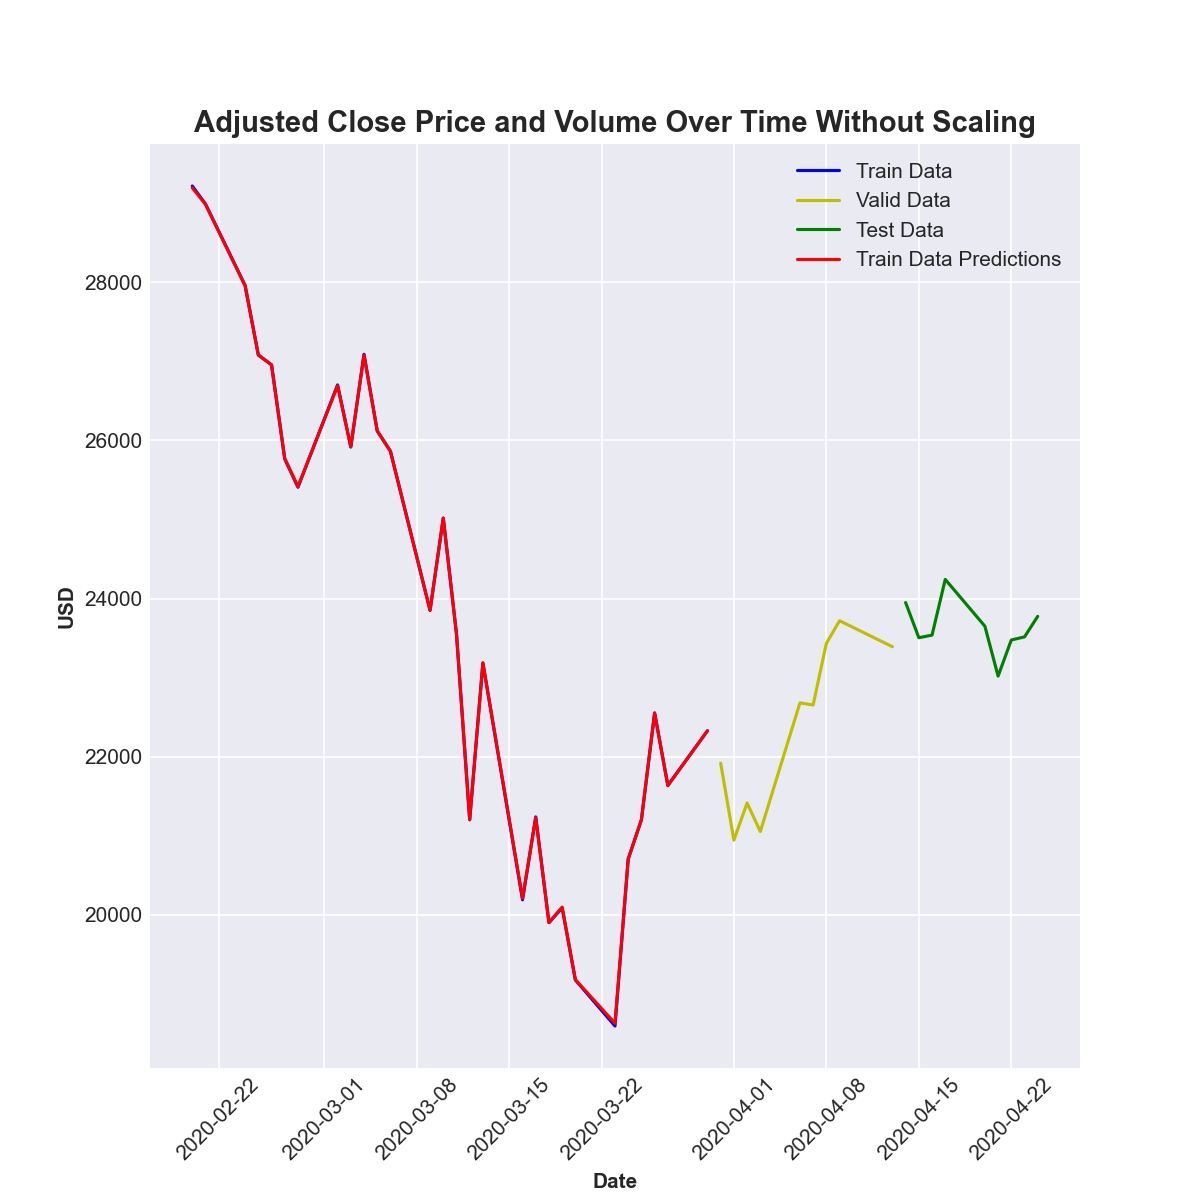

In [24]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_train_df['DATE'], predit_train_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [25]:
predict_valid_scaled = model.predict(X_valid_scaled)
valid['PREDICT_VALID'] = predict_valid_scaled
valid['PREDICT'] = valid['PREDICT_VALID'] * valid['ADJ_CLOSE_STD'] + valid['ADJ_CLOSE_MEAN']

predit_valid_df = pd.DataFrame({'PREDICT_VALUE':valid['PREDICT'],
                               'Y_VALID':y_valid,
                               'DATE':valid['DATE']})

MSE_Original = mean_squared_error(y_valid, valid['PREDICT'])
MAE_Original = mean_absolute_error(y_valid, valid['PREDICT'])

print('MSE on Validation Set =', mean_squared_error(y_valid, valid['PREDICT']))
print('MAE on Validation Set =', mean_absolute_error(y_valid, valid['PREDICT']))

MSE on Validation Set = 1825425.9542405491
MAE on Validation Set = 1129.3725345481607


<ipython-input-25-a804c29ca493>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['PREDICT_VALID'] = predict_valid_scaled
<ipython-input-25-a804c29ca493>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['PREDICT'] = valid['PREDICT_VALID'] * valid['ADJ_CLOSE_STD'] + valid['ADJ_CLOSE_MEAN']


<IPython.core.display.Javascript object>


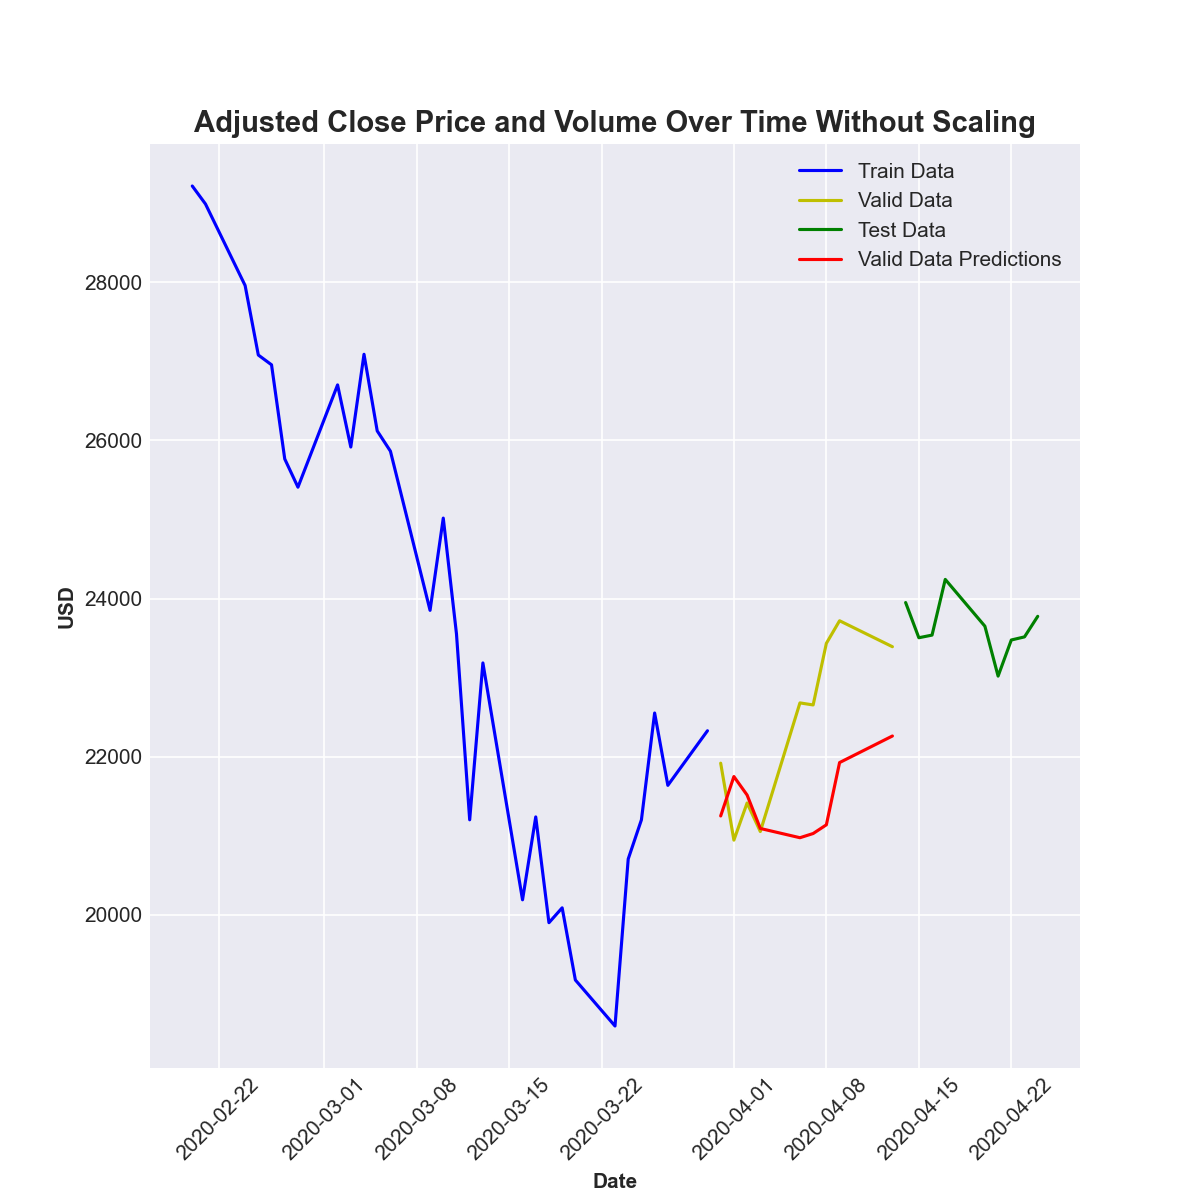

In [26]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_valid_df['DATE'], predit_valid_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Valid Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show();

### Preliminary Analysis

The analysis is clearly showing the predictions are well off. This can be due to the low level data avaialbe for analysis. The positive aspect is the model is able to predict the trend, but does fall short of being accurate. In the world of finance we need efficiency and accuracy. To make this model better, I next went ahead and tuned the hyperparameters of the machine learning model.

### Tuning of XGBoost

First I needed to see what feature list is the most important or the most influential on machine learning model. I then took two parameters at a time of XGBoost and manually optimized the model and storing the optimum values to use for further tuning of the machine learning model.

- XGBoost Parameters:
    - n_estimators -> Specifies how many times to go through the modeling cycle
    - max_depth -> Maximum depth of a tree, large value can cause overfitting
    - learning_rate -> Shrinkage factor that avoids overfitting of the model
    - subsample -> Subsample ratio of the training instances, it will occur once in every boosting iteration
    - colsample_bytree -> Subsample ratio of columns when constructing each tree
    - colsample_bylevel -> Subsample ratio of columns for each level
    - gamma -> Minimum loss reduction required to make a futher partition of a leaf node of the tree

In [27]:
imp = list(zip(train[features_list], model.feature_importances_))
imp.sort(key = lambda tup: tup[1])
imp[-10:]

[('OPEN_LAG_5', 0.008208766),
 ('RANGE_HL_LAG_4', 0.008363764),
 ('ADJ_CLOSE_LAG_15', 0.008747461),
 ('RANGE_OC_LAG_19', 0.009943887),
 ('RANGE_OC_LAG_3', 0.012962766),
 ('RANGE_HL_LAG_3', 0.014451527),
 ('OPEN_LAG_14', 0.025712874),
 ('VOLUME_LAG_14', 0.04882648),
 ('OPEN_LAG_2', 0.07309006),
 ('RANGE_HL_LAG_9', 0.7307866)]

In [28]:
imp = list(zip(train[features_list], model.feature_importances_))
imp.sort(key = lambda tup: tup[1])

imp_10 = imp[-10:]

category = []
value = []

for imp in imp_10:
    category.append(imp[0])
    value.append(imp[1])

imp_df = pd.DataFrame({'FEATURE':category,
                      'IMPORTANCE':value})

imp_df

,FEATURE,IMPORTANCE
0,OPEN_LAG_5,0.008209
1,RANGE_HL_LAG_4,0.008364
2,ADJ_CLOSE_LAG_15,0.008747
3,RANGE_OC_LAG_19,0.009944
4,RANGE_OC_LAG_3,0.012963
5,RANGE_HL_LAG_3,0.014452
6,OPEN_LAG_14,0.025713
7,VOLUME_LAG_14,0.048826
8,OPEN_LAG_2,0.073090
9,RANGE_HL_LAG_9,0.730787


<IPython.core.display.Javascript object>


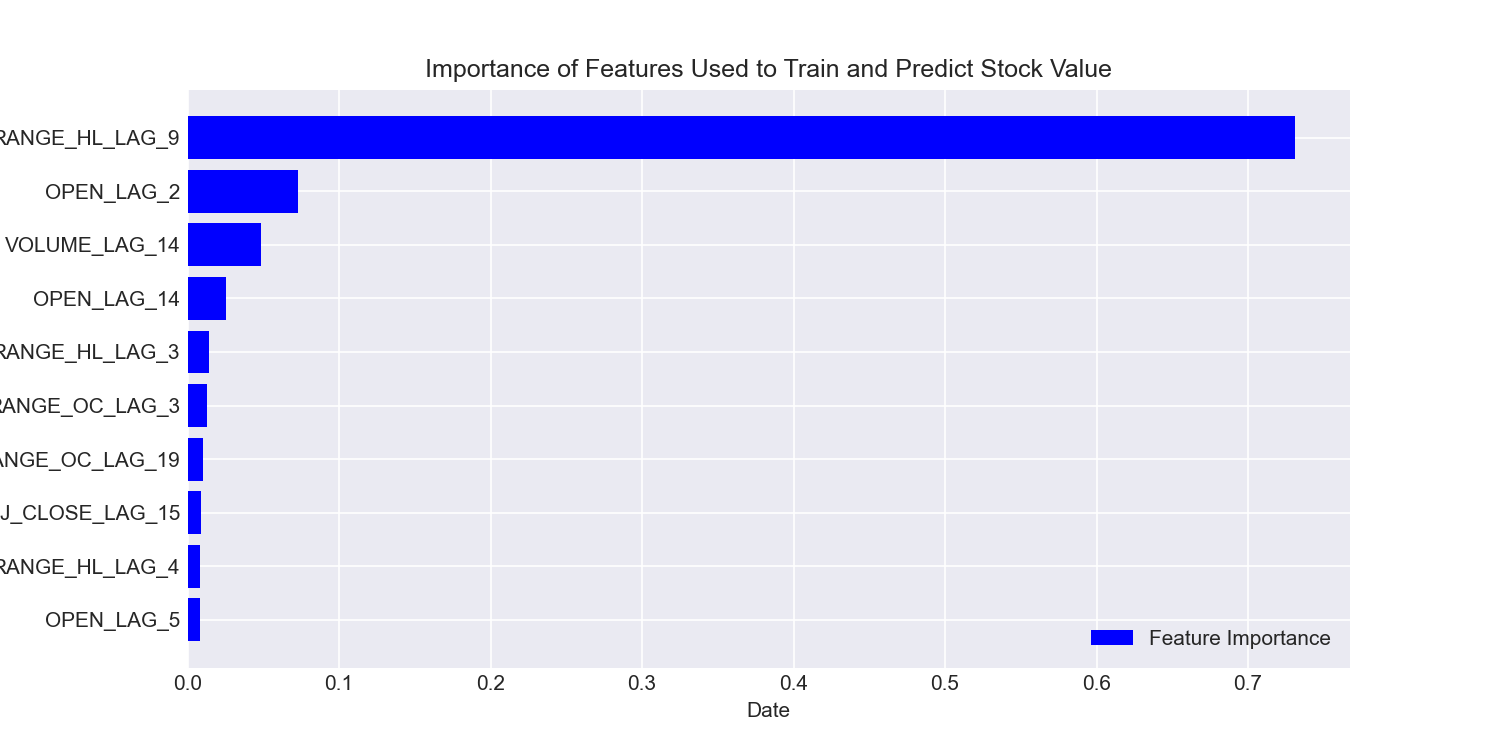

In [29]:
rcParams['figure.figsize'] = 10, 5

plt.figure()

plt.barh(imp_df['FEATURE'], imp_df['IMPORTANCE'], color = 'blue')
plt.legend(['Feature Importance'])
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title('Importance of Features Used to Train and Predict Stock Value')

mplcursors.cursor(hover = True)

plt.show()

In [30]:
n_estimators_parameter = 'n_estimators'
n_estimators_list = range(10, 500, 10)

max_depth_parameter = 'max_depth'
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rates = {n_estimators_parameter: [], max_depth_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(n_estimators_list):
    for param2 in max_depth_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = param,
                                                             max_depth = param2,
                                                             learning_rate = learning_rate,
                                                             min_child_weight = min_child_weight,
                                                             subsample = subsample,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = gamma)
        error_rates[n_estimators_parameter].append(param)
        error_rates[max_depth_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df1 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df1

<ipython-input-30-8cee86291e45>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(n_estimators_list):



Minutes Taken to Execute: 1.063543399175008


,n_estimators,max_depth,MSE,MAE
0,10,2,1.239073e+06,988.882280
1,10,3,1.274104e+06,982.917976
2,10,4,1.274104e+06,982.917976
3,10,5,1.274104e+06,982.917976
4,10,6,1.274104e+06,982.917976
...,...,...,...,...
387,490,5,1.867932e+06,1136.783217
388,490,6,1.869235e+06,1137.089810
389,490,7,1.869235e+06,1137.089810
390,490,8,1.869235e+06,1137.089810


<IPython.core.display.Javascript object>


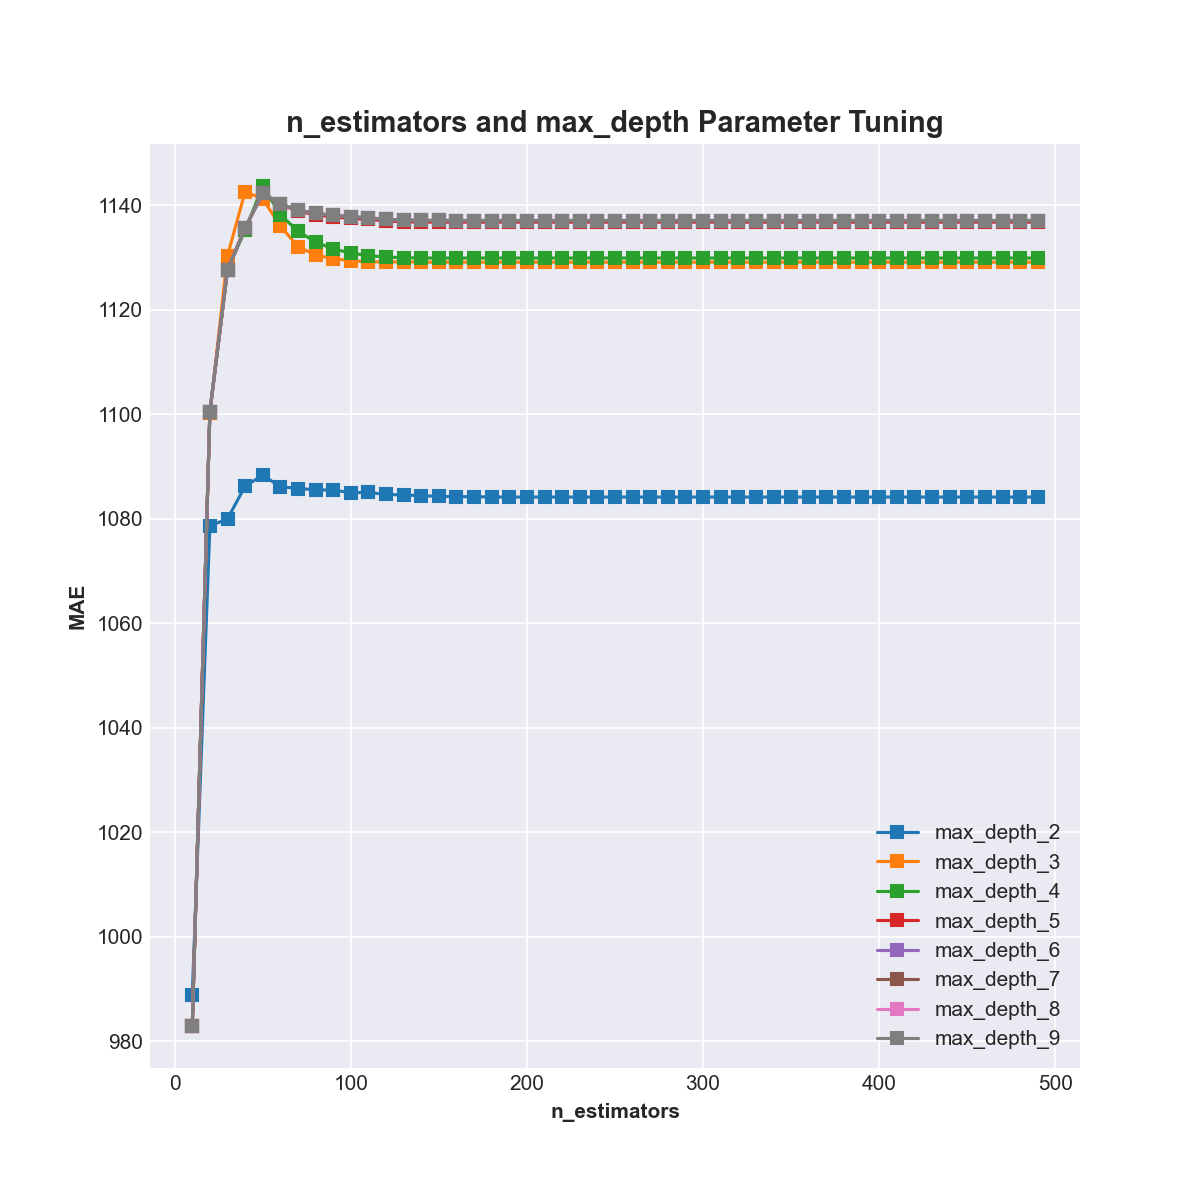

In [31]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(max_depth_list)):
    param = error_rate_df1[error_rate_df1[max_depth_parameter] == max_depth_list[p]]
    plt.plot(param[n_estimators_parameter], param['MAE'], marker = 's',)
    legend_list.append(max_depth_parameter + '_' + str(max_depth_list[p]))
    
plt.xlabel(n_estimators_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('n_estimators and max_depth Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'lower right')

mplcursors.cursor(hover = True)

plt.show();

In [32]:
optimum = error_rate_df1[error_rate_df1['MSE'] == error_rate_df1['MSE'].min()]

print('Minimum MSE Value:', error_rate_df1['MSE'].min())
print('Optimum n_estimators Parameter:', optimum['n_estimators'].values[0])
print('Optimum max_depth Parameter:', optimum['max_depth'].values[0])

Minimum MSE Value: 1239072.8500900385
Optimum n_estimators Parameter: 10
Optimum max_depth Parameter: 2


In [33]:
optimum = error_rate_df1[error_rate_df1['MAE'] == error_rate_df1['MAE'].min()]

n_estimators_optimum = optimum['n_estimators'].values[0]
max_depth_optimum = optimum['max_depth'].values[0]

print('Minimum MAE Value:', error_rate_df1['MAE'].min())
print('Optimum n_estimators Parameter:', optimum['n_estimators'].values[0])
print('Optimum max_depth Parameter:', optimum['max_depth'].values[0])

Minimum MAE Value: 982.9179758004232
Optimum n_estimators Parameter: 10
Optimum max_depth Parameter: 3


In [34]:
learning_rate_parameter = 'learning_rate'
learning_rate_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

min_child_weight_parameter = 'min_child_weight'
min_child_weight_list = range(5, 21, 1)

error_rates = {learning_rate_parameter: [], min_child_weight_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(learning_rate_list):
    for param2 in min_child_weight_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = param,
                                                             min_child_weight = param2,
                                                             subsample = subsample,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = gamma)
        error_rates[learning_rate_parameter].append(param)
        error_rates[min_child_weight_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df2 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df2

<ipython-input-34-5e425274f179>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(learning_rate_list):



Minutes Taken to Execute: 0.042429586251576744


,learning_rate,min_child_weight,MSE,MAE
0,0.001,5,7.484336e+05,778.204523
1,0.001,6,7.488344e+05,778.489739
2,0.001,7,7.497319e+05,779.517483
3,0.001,8,7.502063e+05,779.201701
4,0.001,9,7.502063e+05,779.201701
...,...,...,...,...
107,0.300,16,1.039936e+06,918.023606
108,0.300,17,1.039936e+06,918.023606
109,0.300,18,1.039936e+06,918.023606
110,0.300,19,1.039936e+06,918.023606


<IPython.core.display.Javascript object>


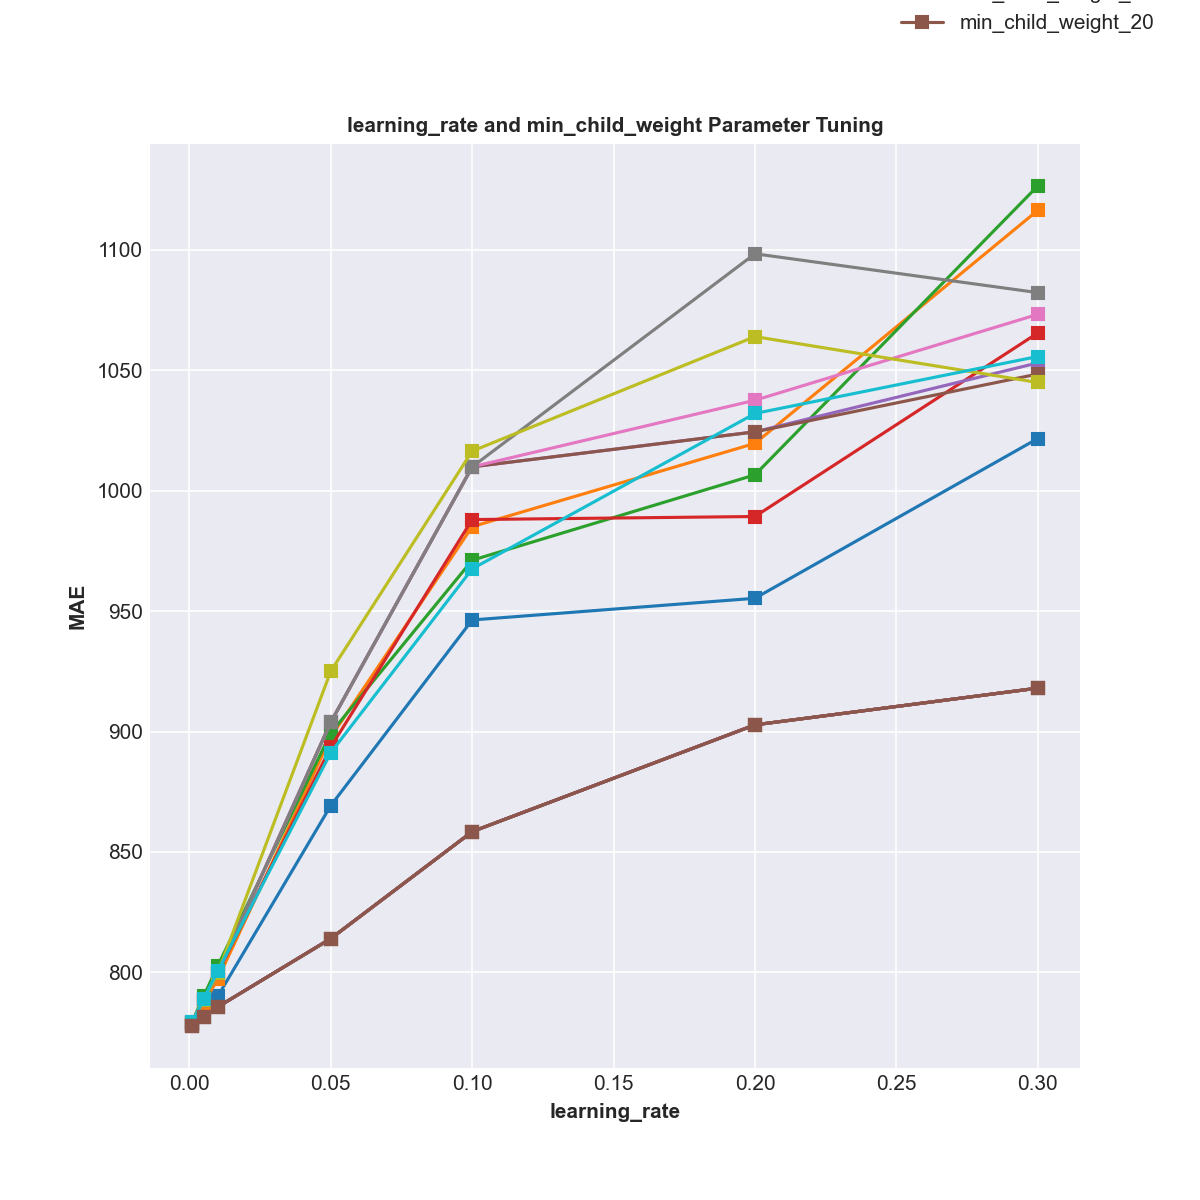

In [35]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(min_child_weight_list)):
    param = error_rate_df2[error_rate_df2[min_child_weight_parameter] == min_child_weight_list[p]]
    plt.plot(param[learning_rate_parameter], param['MAE'], marker = 's',)
    legend_list.append(min_child_weight_parameter + '_' + str(min_child_weight_list[p]))
    
plt.xlabel(learning_rate_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('learning_rate and min_child_weight Parameter Tuning', fontsize = 10, fontweight = 'bold')
plt.legend(legend_list, loc = 'lower right', bbox_to_anchor = (1.1, 1.1))

mplcursors.cursor(hover = True)

plt.show();

In [36]:
optimum = error_rate_df2[error_rate_df2['MSE'] == error_rate_df2['MSE'].min()]

print('Minimum MSE Value:', error_rate_df2['MSE'].min())
print('Optimum learning_rate Parameter:', optimum['learning_rate'].values[0])
print('Optimum min_child_weight Parameter:', optimum['min_child_weight'].values[0])

Minimum MSE Value: 747630.2683270355
Optimum learning_rate Parameter: 0.001
Optimum min_child_weight Parameter: 15


In [37]:
optimum = error_rate_df2[error_rate_df2['MAE'] == error_rate_df2['MAE'].min()]

learning_rate_optimum = optimum['learning_rate'].values[0]
min_child_weight_optimum = optimum['min_child_weight'].values[0]

print('Minimum MAE Value:', error_rate_df2['MAE'].min())
print('Optimum learning_rate Parameter:', optimum['learning_rate'].values[0])
print('Optimum min_child_weight Parameter:', optimum['min_child_weight'].values[0])

Minimum MAE Value: 777.7536293103929
Optimum learning_rate Parameter: 0.001
Optimum min_child_weight Parameter: 15


In [38]:
subsample_parameter = 'subsample'
subsample_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

gamma_parameter = 'gamma'
gamma_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

error_rates = {subsample_parameter: [], gamma_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(subsample_list):
    for param2 in gamma_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = param,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = param2)
        error_rates[subsample_parameter].append(param)
        error_rates[gamma_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df3 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df3

<ipython-input-38-000a039edf79>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(subsample_list):



Minutes Taken to Execute: 0.0363974650700887


,subsample,gamma,MSE,MAE
0,0.1,0.1,747686.434324,777.785605
1,0.1,0.2,747686.434324,777.785605
2,0.1,0.3,747686.434324,777.785605
3,0.1,0.4,747686.434324,777.785605
4,0.1,0.5,747686.434324,777.785605
...,...,...,...,...
95,1.0,0.6,747630.268327,777.753629
96,1.0,0.7,747630.268327,777.753629
97,1.0,0.8,747630.268327,777.753629
98,1.0,0.9,747630.268327,777.753629


<IPython.core.display.Javascript object>


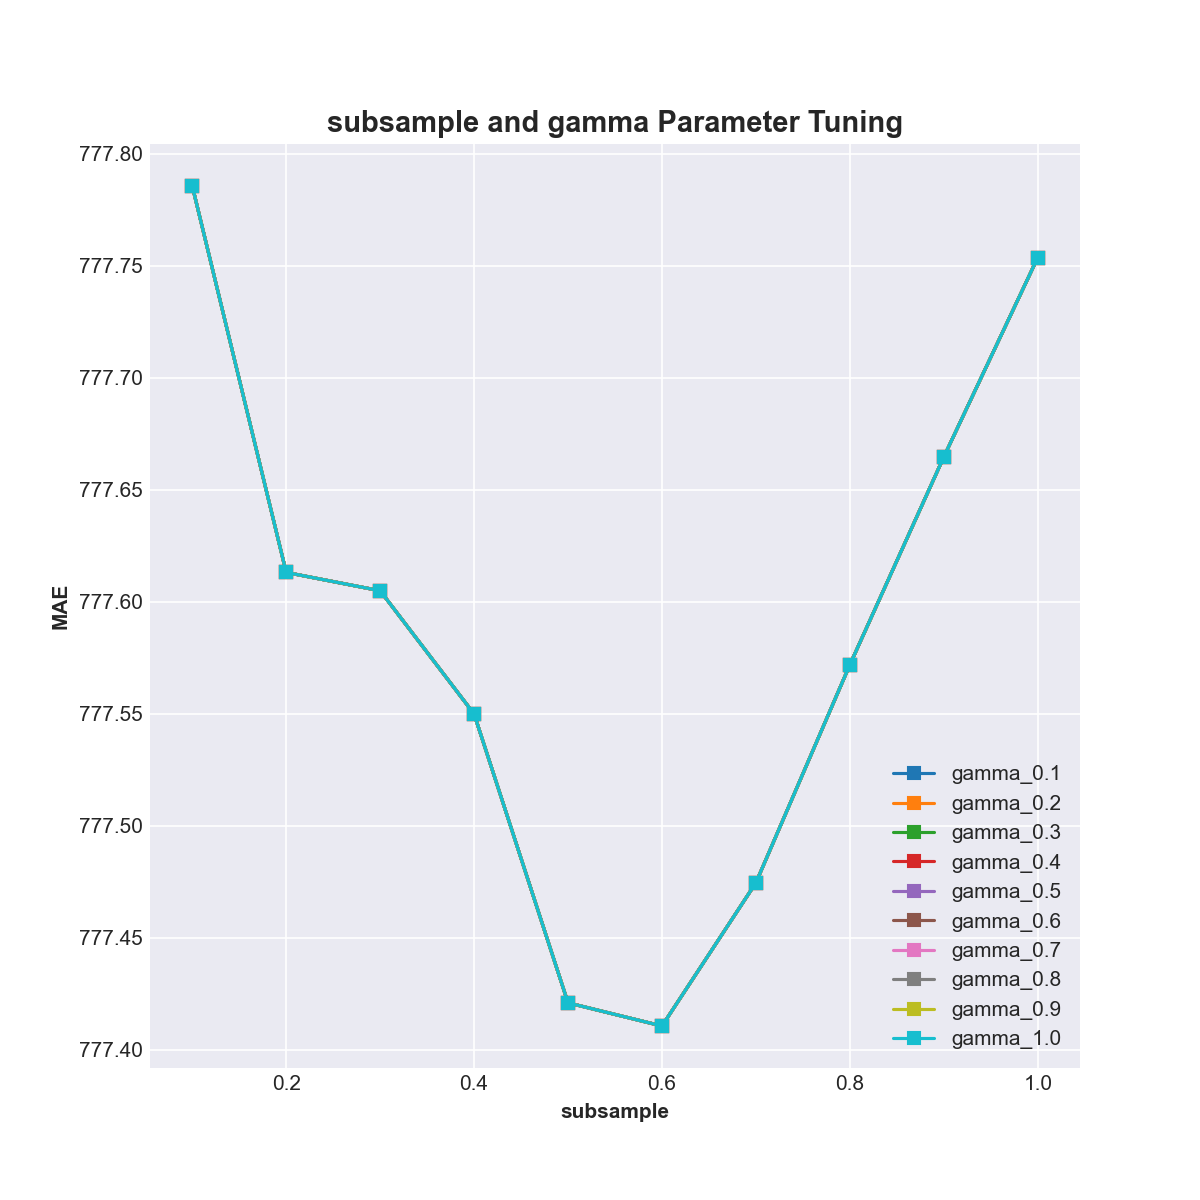

In [39]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(gamma_list)):
    param = error_rate_df3[error_rate_df3[gamma_parameter] == gamma_list[p]]
    plt.plot(param[subsample_parameter], param['MAE'], marker = 's',)
    legend_list.append(gamma_parameter + '_' + str(gamma_list[p]))
    
plt.xlabel(subsample_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('subsample and gamma Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'lower right')

mplcursors.cursor(hover = True)

plt.show();

In [40]:
optimum = error_rate_df3[error_rate_df3['MSE'] == error_rate_df3['MSE'].min()]

print('Minimum MSE Value:', error_rate_df3['MSE'].min())
print('Optimum subsample Parameter:', optimum['subsample'].values[0])
print('Optimum gamma Parameter:', optimum['gamma'].values[0])

Minimum MSE Value: 747029.8728928478
Optimum subsample Parameter: 0.6
Optimum gamma Parameter: 0.1


In [41]:
optimum = error_rate_df3[error_rate_df3['MAE'] == error_rate_df3['MAE'].min()]

subsample_optimum = optimum['subsample'].values[0]
gamma_optimum = optimum['gamma'].values[0]

print('Minimum MAE Value:', error_rate_df3['MAE'].min())
print('Optimum subsample Parameter:', optimum['subsample'].values[0])
print('Optimum gamma Parameter:', optimum['gamma'].values[0])

Minimum MAE Value: 777.4106658556686
Optimum subsample Parameter: 0.6
Optimum gamma Parameter: 0.1


In [42]:
colsample_bytree_parameter = 'colsample_bytree'
colsample_bytree_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

colsample_bylevel_parameter = 'colsample_bylevel'
colsample_bylevel_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

error_rates = {colsample_bytree_parameter: [], colsample_bylevel_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(colsample_bytree_list):
    for param2 in colsample_bylevel_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = subsample_optimum,
                                                             colsample_bytree = param,
                                                             colsample_bylevel = param2,
                                                             gamma = gamma_optimum)
        error_rates[colsample_bytree_parameter].append(param)
        error_rates[colsample_bylevel_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df4 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df4

<ipython-input-42-e3d8ff646ff8>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(colsample_bytree_list):



Minutes Taken to Execute: 0.013480850060780843


,colsample_bytree,colsample_bylevel,MSE,MAE
0,0.5,0.5,747029.872893,777.410666
1,0.5,0.6,747029.872893,777.410666
2,0.5,0.7,747029.872893,777.410666
3,0.5,0.8,747029.872893,777.410666
4,0.5,0.9,747029.872893,777.410666
5,0.5,1.0,747029.872893,777.410666
6,0.6,0.5,747029.872893,777.410666
7,0.6,0.6,747029.872893,777.410666
8,0.6,0.7,747029.872893,777.410666
9,0.6,0.8,747029.872893,777.410666


<IPython.core.display.Javascript object>


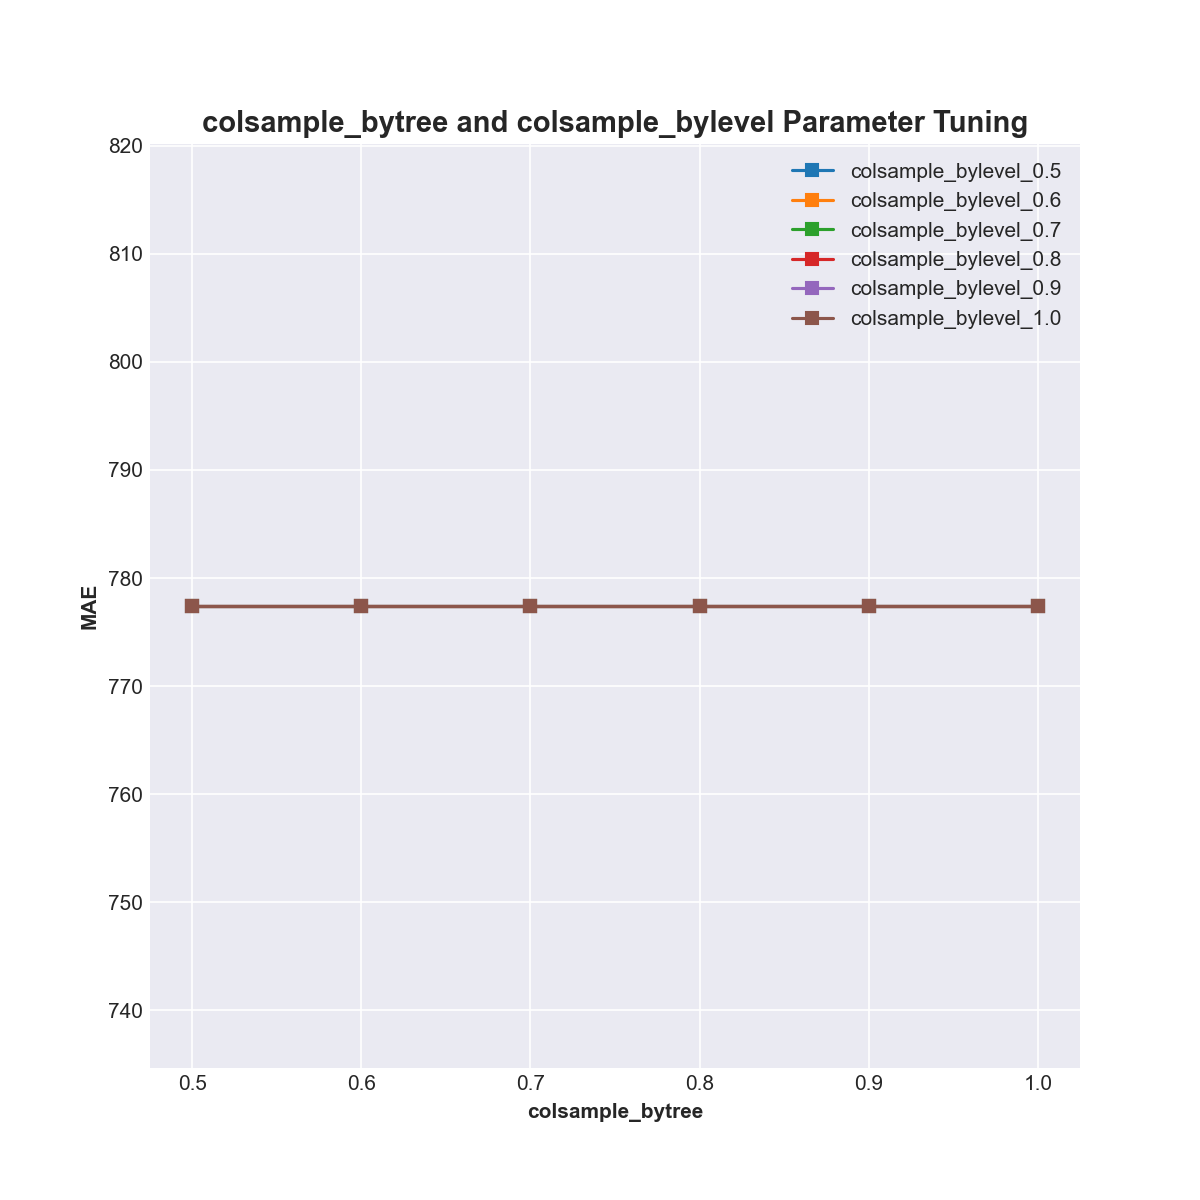

In [43]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(colsample_bylevel_list)):
    param = error_rate_df4[error_rate_df4[colsample_bylevel_parameter] == colsample_bylevel_list[p]]
    plt.plot(param[colsample_bytree_parameter], param['MAE'], marker = 's',)
    legend_list.append(colsample_bylevel_parameter + '_' + str(colsample_bylevel_list[p]))
    
plt.xlabel(colsample_bytree_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('colsample_bytree and colsample_bylevel Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right')

mplcursors.cursor(hover = True)

plt.show();

In [44]:
optimum = error_rate_df4[error_rate_df4['MSE'] == error_rate_df4['MSE'].min()]

MSE_Optimum = error_rate_df4['MSE'].min()

print('Minimum MSE Value:', error_rate_df4['MSE'].min())
print('Optimum colsample_bytree Parameter:', optimum['colsample_bytree'].values[0])
print('Optimum colsample_bylevel Parameter:', optimum['colsample_bylevel'].values[0])

Minimum MSE Value: 747029.8728928478
Optimum colsample_bytree Parameter: 0.5
Optimum colsample_bylevel Parameter: 0.5


In [45]:
optimum = error_rate_df4[error_rate_df4['MAE'] == error_rate_df4['MAE'].min()]

MAE_Optimum = error_rate_df4['MAE'].min()

colsample_bytree_optimum = optimum['colsample_bytree'].values[0]
colsample_bylevel_optimum = optimum['colsample_bylevel'].values[0]

print('Minimum MAE Value:', error_rate_df4['MAE'].min())
print('Optimum colsample_bytree Parameter:', optimum['colsample_bytree'].values[0])
print('Optimum colsample_bylevel Parameter:', optimum['colsample_bylevel'].values[0])

Minimum MAE Value: 777.4106658556686
Optimum colsample_bytree Parameter: 0.5
Optimum colsample_bylevel Parameter: 0.5


### Overview of Optimized Values

I have graphed the opimized values to visually represent this analysis and clearly understand what the new values are and how the error values are impacted to show the effect of tuning parameters.

In [46]:
tuned_params_df = pd.DataFrame({'PARAMETER':['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma'],
                               'ORIGINAL':[n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma],
                               'OPTIMUM':[n_estimators_optimum, max_depth_optimum, learning_rate_optimum, min_child_weight_optimum, subsample_optimum, colsample_bytree_optimum, colsample_bylevel_optimum, gamma_optimum]})

MSE_values_df = pd.DataFrame({'PARAMETER':['MSE'],
                                    'ORIGINAL':[MSE_Original],
                                    'OPTIMUM':[MSE_Optimum]})

MAE_values_df = pd.DataFrame({'PARAMETER':['MAE'],
                                    'ORIGINAL':[MAE_Original],
                                    'OPTIMUM':[MAE_Optimum]})

tuned_params_df

,PARAMETER,ORIGINAL,OPTIMUM
0,n_estimators,100.0,10.000
1,max_depth,3.0,3.000
2,learning_rate,0.1,0.001
3,min_child_weight,1.0,15.000
4,subsample,1.0,0.600
5,colsample_bytree,1.0,0.500
6,colsample_bylevel,1.0,0.500
7,gamma,0.0,0.100


In [47]:
MSE_values_df

,PARAMETER,ORIGINAL,OPTIMUM
0,MSE,1.825426e+06,747029.872893


In [48]:
MAE_values_df

,PARAMETER,ORIGINAL,OPTIMUM
0,MAE,1129.372535,777.410666


<IPython.core.display.Javascript object>


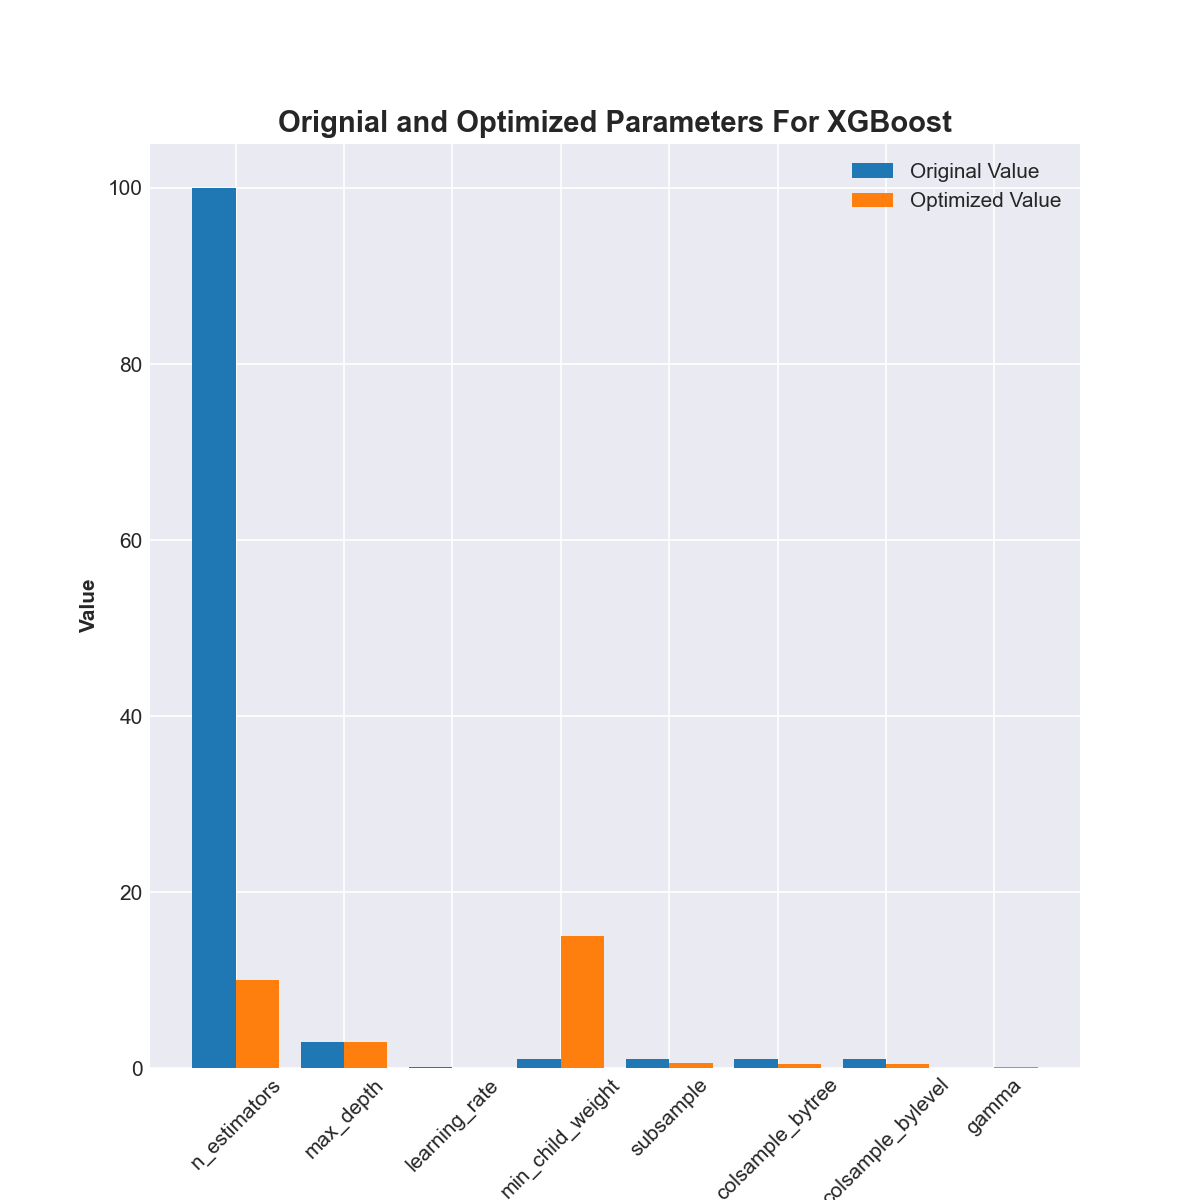

In [49]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_parameters = [tuned_params_df['ORIGINAL'], tuned_params_df['OPTIMUM']]
X_parameters = tuned_params_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_parameters)
_X = np.arange(len(X_parameters))
for i in range(len(vals_parameters)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_parameters[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_parameters, rotation=45)
plt.title('Orignial and Optimized Parameters For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Parameters', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

<IPython.core.display.Javascript object>


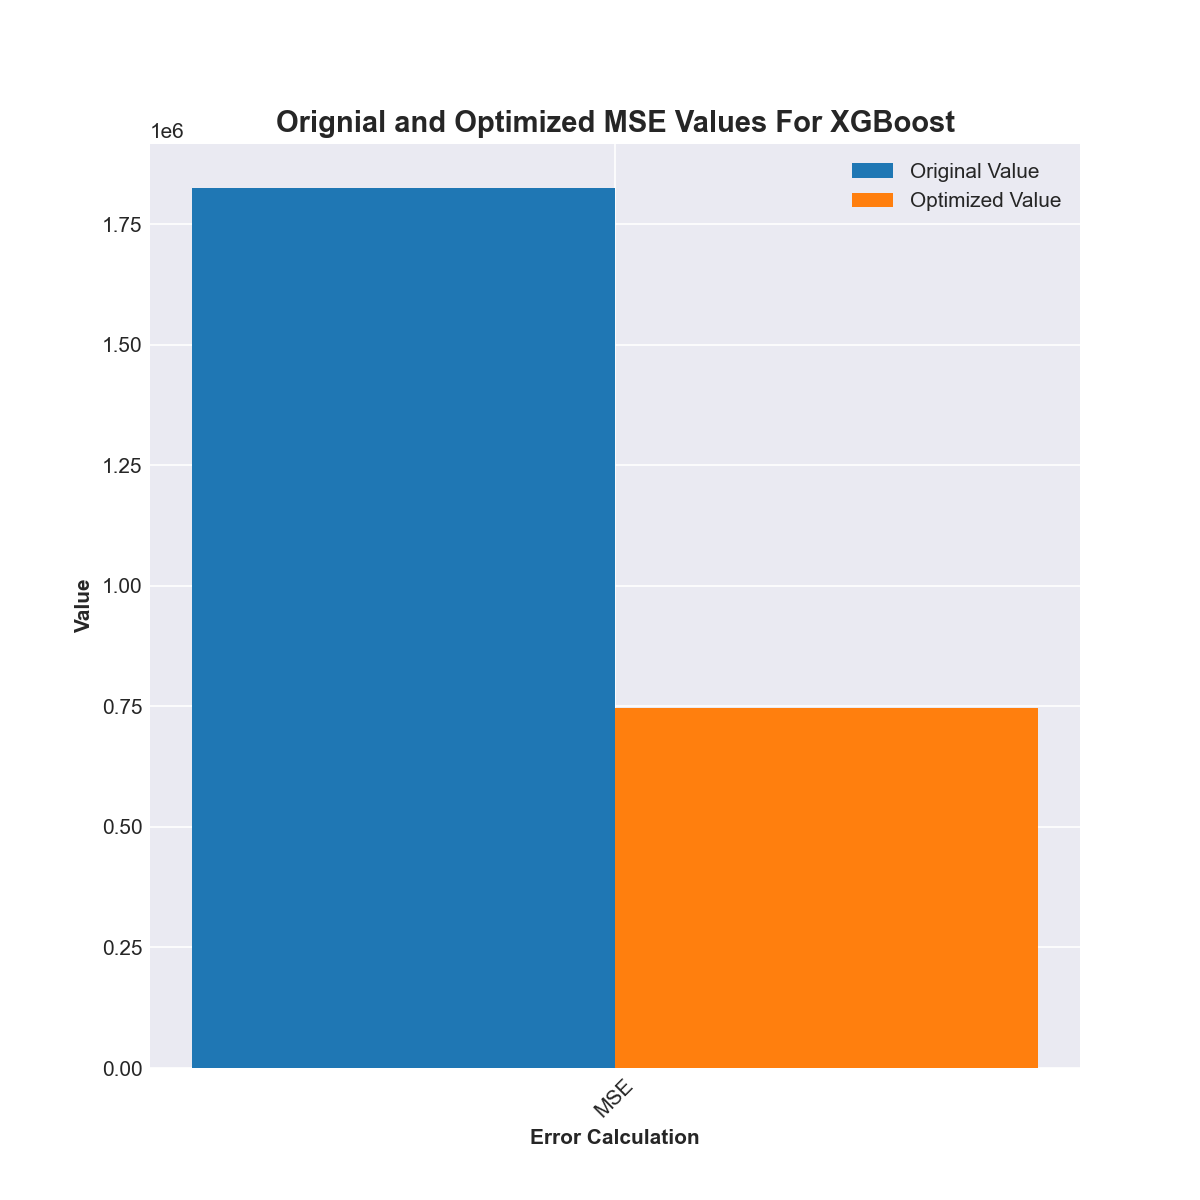

In [50]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_MSE = [MSE_values_df['ORIGINAL'], MSE_values_df['OPTIMUM']]
X_MSE = MSE_values_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_MSE)
_X = np.arange(len(X_MSE))
for i in range(len(vals_MSE)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_MSE[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_MSE, rotation=45)
plt.title('Orignial and Optimized MSE Values For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Error Calculation', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

<IPython.core.display.Javascript object>


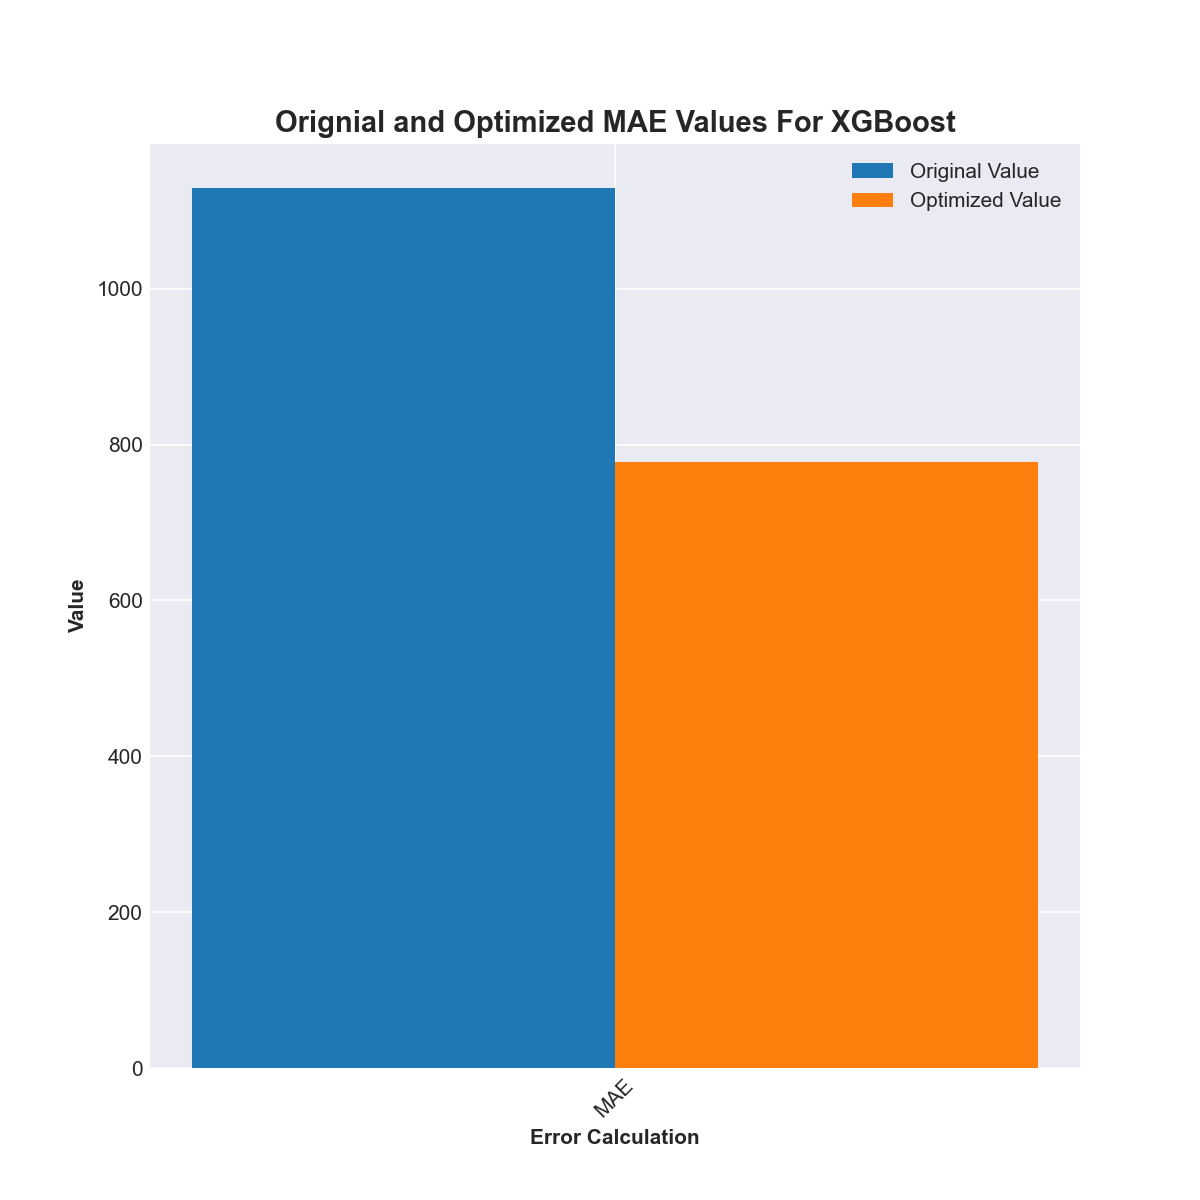

In [51]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_MAE = [MAE_values_df['ORIGINAL'], MAE_values_df['OPTIMUM']]
X_MAE = MAE_values_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_MAE)
_X = np.arange(len(X_MAE))
for i in range(len(vals_MAE)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_MAE[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_MAE, rotation=45)
plt.title('Orignial and Optimized MAE Values For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Error Calculation', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

### Testing XGBoost Model on Test Dataset

After seeing that the optimum parameters are having a positive effect on the error values, making it more accurate model to use for predictions.

In [52]:
mse, mae, predicted_test = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             test['ADJ_CLOSE_MEAN'],
                                                             test['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = subsample_optimum,
                                                             colsample_bytree = colsample_bytree_optimum,
                                                             colsample_bylevel = colsample_bylevel_optimum,
                                                             gamma = gamma_optimum)


predit_test_df = pd.DataFrame({'PREDICT_VALUE':predicted_test,
                               'Y_TEST':y_test,
                               'DATE':test['DATE']})

print('MSE Value:', mse)
print('MAE Value:', mae)

MSE Value: 2844446.372427358
MAE Value: 1397.1496077750546


<IPython.core.display.Javascript object>


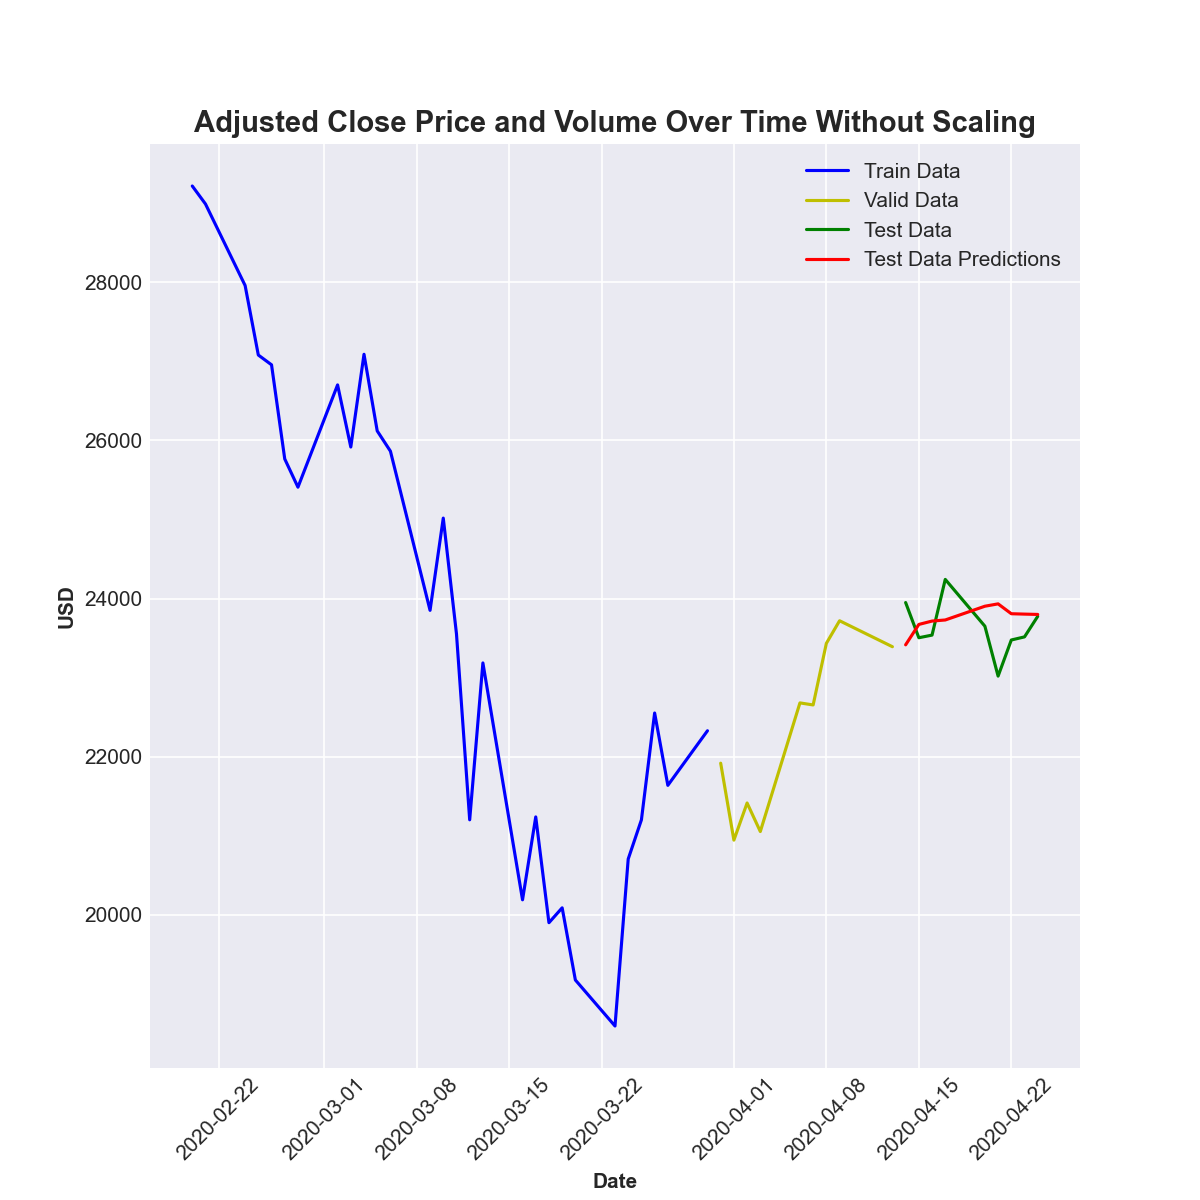

In [53]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_test_df['DATE'], predit_test_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Test Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.xticks(rotation = 45)
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')

mplcursors.cursor(hover = True)

plt.show();

### Conclusion/Analysis

__With the tuned XGBoost, I am still having a difficulty producing accurate predictions. After tuning my Mean Square Error is 2844446, and my mean absolute error is 1397. I am able to still get some level of a trend, but the accruacy is very low.__

__Next Stpes__:
    - Change the data that we are feeding into the model for better accuracy. 
        - One of the inconsistencies to fix is taking out the OHLC data that is fed into the model, if we want to only focus on COVID-19 cases and their effect on the stock market. 
    - Use news and twitter sentimental analysis to see how news on COVID-19 can suppliment the analysis and predictions of the machine learning model. 
    - Use hospitilization and death rates along with case count to better account for the devastation COVID-19.
    - Use 10Q (Quarterly Reports), cash flow statements, and any other financial statments to get a better understanding of how the stay at home orders and freeze in the economy has affected companies
    
Although the model is not perfect there is great opportunites for improvement and make it much more accurate. As more data is released to the public over the year, and with other data incorporated into the model, I believe we can be more prepared for future pandemics that come our way.